In [1]:
import sys
import os

import pandas as pd

import logging

import sklearn
from sklearn import metrics
from sklearn.model_selection import KFold, train_test_split

In [2]:
sys.path.append('lib')

from train_models import prepare_training, train_classifiers
from predict_labels import BARModels
from bar_tools import plot_confusion_matrix

In [3]:
# set up logging

logger = logging.getLogger()
logger.setLevel('INFO')

## Set up paths and parameters

In [4]:
in_path = '../data_syn/annotated_data_example.tsv'  # path to training data
models_dir = '../saved_models'

In [5]:
dictionary_paths = {'personnames_path': '../data_syn//dictionaries/personnames.tsv',
                    'placenames_path': '../data_syn/dictionaries/schweizer_ortsnamen-wikipedia.csv',
                    'firmnames_path': '../data_syn/dictionaries/firmnames_unigrams.tsv',
                    'commonwords_path': '../data_syn/dictionaries/deu_news_2010_1M-words-LOWER.tsv'}

In [6]:
anno_field = 'TITEL'
context_field = 'HIERARCHIE'
id_field = 'IDENTIFIER'
context_window = '4'

## Prepare Data

In [7]:
# read data into data frame
in_df = pd.read_csv(in_path, sep='\t')
in_df

,IDENTIFIER,HIERARCHIE,TITEL
0,ID-10000,Straffälle\r\n - \r\n - \r\n - und Ausfuhrre...,"YU: <j>Vahuret</j>, Givisiez CH-FR"
1,ID-20000,"Informelles, Vorprüfung, Prüfung und Rechtsmit...","<j>Emacite, S.A.</j> (<wd>7.4.</wd> - <wd>31.5..."
2,ID-30000,Dossier N 141000 - 141999\r\n - Asyldossiers\r...,<n>Anopug</n> . <d>14.03.1976</d>
3,ID-40000,Benutzer \r\n - Benützer (LfNr) / Standort d...,<n>Presseservice Epihu GmbH</n>
4,ID-2529,Rechtshilfegesuche Laufnummern 35000 - 39999\r...,"<n>COVAS, Icidu</n>, weitere"
...,...,...,...
998,ID-1193,"Responsabilités du Zaire, Pillage etc.\r\n - S...","<n>Uvuv, Eucöw</n> Frères"
999,ID-1559,Cas particuliers\r\n - Créances et recouvremen...,"<j>Eni, AG</j> , Tissage et Finissage"
1000,ID-2779,Rechtshilfegesuche Laufnummern 70000 - 74999\r...,"<n>OYUYODUPU, Vunug</n>, <d>01.07.1978</d>, we..."
1001,ID-2440,Beschwerden\r\n - Rechtsdienst\r\n - Stab der ...,"<n>Bodota, Cigodi</n> - Dienstbeschwerde betre..."


### Run Feature Extraction

Calling ```prepare_training``` (imported from ```train_models.py```) generates four different objects:
- ```tok_feat_df```: token-level features
- ```doc_feat_df```: document-level features (list of feature dictionaries, one per token)


- ```tok_anno```: token-level annotations 
- ```doc_annos```: document-level annotations (a list of token-level annotations per document)




In [8]:
((tok_feat_df, tok_anno), (doc_feat_df, doc_anno)) = prepare_training(in_df, dictionary_paths, anno_field=anno_field, context_field=context_field, id_field=id_field)

INFO:root:Number of lines in input data: 1003
INFO:root:Tokenizer initiated
INFO:root:Building feature overview... (This may take some time)


In [9]:
# Token-level features and annotation

print(tok_feat_df)
print(tok_anno)

      IDENTIFIER  td-idx                                       tok_features
0       ID-10000       0  {'token': 'YU', 'pos_fine': 'NE', 'lemma': 'YU...
1       ID-10000       1  {'token': ':', 'pos_fine': '$.', 'lemma': ':',...
2       ID-10000       2  {'token': 'Vahuret', 'pos_fine': 'NE', 'lemma'...
3       ID-10000       3  {'token': ',', 'pos_fine': '$,', 'lemma': ',',...
4       ID-10000       4  {'token': 'Givisiez', 'pos_fine': 'NE', 'lemma...
...          ...     ...                                                ...
11596    ID-2440   11596  {'token': 'RS', 'pos_fine': 'NE', 'lemma': 'RS...
11597    ID-2440   11597  {'token': '72', 'pos_fine': 'CARD', 'lemma': '...
11598    ID-2440   11598  {'token': '/', 'pos_fine': '$(', 'lemma': '/',...
11599    ID-2440   11599  {'token': '73', 'pos_fine': 'CARD', 'lemma': '...
11600     ID-178   11600  {'token': 'Ovem', 'pos_fine': 'NN', 'lemma': '...

[11601 rows x 3 columns]
      IDENTIFIER  td-idx annotation
0       ID-10000       0  

In [10]:
# An example of a token-level feature dictionary

tok_feat_df.iloc[0]['tok_features']

{'token': 'YU',
 'pos_fine': 'NE',
 'lemma': 'YU',
 'lower': 'yu',
 'shape': 'XX',
 'is_alpha': 'True',
 'is_digit': 'False',
 'is_punct': 'False',
 'is_left_punct': 'False',
 'is_right_punct': 'False',
 'like_num': 'False',
 'is_stop': 'False',
 'datecheck': 'False',
 'ahvcheck': 'False',
 'hierarchie': ' Stra',
 'in_personnames': 'False',
 'in_swissplaces': 'False',
 'in_register': 'False',
 'common_words': 'True',
 'length': '2',
 'in_hier:Beziehungen': 'True',
 'in_hier:Warenverkehr': 'True',
 'in_hier:einzelnen': 'True',
 'in_hier:und': 'True',
 'in_hier:Straffälle': 'True',
 'in_hier:zu': 'True',
 'in_hier:Ausfuhrregelungen': 'True',
 'in_hier:Staaten': 'True',
 's_ngram:X': 'True',
 'lower-1': 'BOS',
 'lower+1': ':',
 'pos+1': '$.',
 'is_punct+1': 'True',
 'shape+1': ':',
 'lower-2': 'BOS',
 'lower+2': 'vahuret',
 'pos+2': 'NE',
 'is_punct+2': 'False',
 'shape+2': 'Xxxxx',
 'lower-3': 'BOS',
 'lower+3': ',',
 'pos+3': '$,',
 'is_punct+3': 'True',
 'shape+3': ',',
 'lower-4': 'BO

In [11]:
# Document-level features and annotation

print(doc_feat_df)
print(doc_anno)

     IDENTIFIER                                       doc_features
0      ID-10000  [{'token': 'YU', 'pos_fine': 'NE', 'lemma': 'Y...
1      ID-20000  [{'token': 'Emacite', 'pos_fine': 'NN', 'lemma...
2      ID-30000  [{'token': 'Anopug', 'pos_fine': 'NN', 'lemma'...
3      ID-40000  [{'token': 'Presseservice', 'pos_fine': 'NN', ...
4       ID-2529  [{'token': 'COVAS', 'pos_fine': 'NE', 'lemma':...
...         ...                                                ...
998     ID-1193  [{'token': 'Uvuv', 'pos_fine': 'NE', 'lemma': ...
999     ID-1559  [{'token': 'Eni', 'pos_fine': 'NE', 'lemma': '...
1000    ID-2779  [{'token': 'OYUYODUPU', 'pos_fine': 'NE', 'lem...
1001    ID-2440  [{'token': 'Bodota', 'pos_fine': 'NE', 'lemma'...
1002     ID-178  [{'token': 'Ovem', 'pos_fine': 'NN', 'lemma': ...

[1003 rows x 2 columns]
     IDENTIFIER                                         annotation
0      ID-10000                           [O, p, j, p, O, O, p, O]
1      ID-20000  [j, j, j, j, j, p, w

## Training

In [12]:
# All document ids in the data set
doc_ids = doc_anno[id_field]

### Split the documents in the overall data set into training and test set

In [13]:
## train-test split (over document ids): 80% train -- 20% test
docs_train, docs_test = train_test_split(doc_ids, test_size=0.2, random_state=42)
print(len(docs_train), len(docs_test))

802 201


In [14]:
# divide document-level features and annotations into training and test set

in_train_docs = doc_feat_df[id_field].isin(docs_train)

doc_feat_df_train = doc_feat_df[in_train_docs]  # training set features
print(doc_feat_df_train.shape)
doc_anno_train = doc_anno[in_train_docs]
print(doc_anno_train.shape)
print(doc_anno_train)
print(doc_feat_df_train)


doc_feat_df_test = doc_feat_df[~in_train_docs].copy()
doc_anno_test = doc_feat_df[~in_train_docs].copy()
print(doc_anno_test.shape)

(802, 2)
(802, 2)
     IDENTIFIER                                         annotation
0      ID-10000                           [O, p, j, p, O, O, p, O]
1      ID-20000  [j, j, j, j, j, p, wd, wd, wd, p, wd, wd, wd, ...
2      ID-30000                              [n, p, d, d, d, d, d]
3      ID-40000                                          [n, n, n]
4       ID-2529                                    [n, n, n, p, O]
...         ...                                                ...
997     ID-2355  [n, n, n, n, p, O, p, O, a, a, a, a, a, p, O, ...
999     ID-1559                              [j, j, j, p, O, O, O]
1000    ID-2779                  [n, n, n, p, d, d, d, d, d, p, O]
1001    ID-2440      [n, n, n, p, O, O, O, O, O, O, O, O, O, p, O]
1002     ID-178                                                [j]

[802 rows x 2 columns]
     IDENTIFIER                                       doc_features
0      ID-10000  [{'token': 'YU', 'pos_fine': 'NE', 'lemma': 'Y...
1      ID-20000  [{'

In [15]:
# divide token-level features and annotations into training and test set

in_train_toks = tok_anno[id_field].isin(docs_train)

tok_feat_df_train = tok_feat_df[in_train_toks]
tok_anno_train = tok_anno[in_train_toks]
print(tok_feat_df_train.shape, tok_anno_train.shape)
print(tok_anno_train)
print(tok_feat_df_train)

tok_feat_df_test = tok_feat_df[~in_train_toks].copy()
tok_anno_test = tok_anno[~in_train_toks].copy()
print(tok_anno_test.shape)

(9226, 3) (9226, 3)
      IDENTIFIER  td-idx annotation
0       ID-10000       0          O
1       ID-10000       1          p
2       ID-10000       2          j
3       ID-10000       3          p
4       ID-10000       4          O
...          ...     ...        ...
11596    ID-2440   11596          O
11597    ID-2440   11597          O
11598    ID-2440   11598          p
11599    ID-2440   11599          O
11600     ID-178   11600          j

[9226 rows x 3 columns]
      IDENTIFIER  td-idx                                       tok_features
0       ID-10000       0  {'token': 'YU', 'pos_fine': 'NE', 'lemma': 'YU...
1       ID-10000       1  {'token': ':', 'pos_fine': '$.', 'lemma': ':',...
2       ID-10000       2  {'token': 'Vahuret', 'pos_fine': 'NE', 'lemma'...
3       ID-10000       3  {'token': ',', 'pos_fine': '$,', 'lemma': ',',...
4       ID-10000       4  {'token': 'Givisiez', 'pos_fine': 'NE', 'lemma...
...          ...     ...                                           

### Run the training

- Call ```train_classifiers``` function imported from ```train_models.py```
- This returns all trained models and the vectorizer
    - (all of these could also be saved using joblib and then reloaded to be used for the labeling of unseen data)

In [16]:
crf_model, mlp_model, svm_model, vectorizer = train_classifiers(doc_feat_df_train,
                                                                doc_anno_train,
                                                                tok_feat_df_train,
                                                                tok_anno_train)

# dictionary containing all trained models and the vectorizer (to be used within BARModels)
models_dict = {'crf_model': crf_model, 'mlp_model': mlp_model, 'svm_model': svm_model, 'vectorizer': vectorizer}

INFO:root:Training CRF classifier...
INFO:root:CRF model: training completed.
INFO:root:Training MLP Classifier...
INFO:root:MLP model: training completed.
INFO:root:Training SVM Classifier...
INFO:root:SVM model: training completed
INFO:root:Training of ensemble subsystems completed.


## Apply

- Instatiates ```BARModels``` with the models dictionary
- With the ```relabeler``` set to ```True``` relabeling according to rules (i.e. after titles like *Prof.* and *Dr.*) is applied

In [17]:
models = BARModels(models_dict=models_dict, relabeler=True)

In [18]:
test_preds = models.predict_labels(doc_feat_df_test, tok_feat_df_test, id_field=id_field)

INFO:root:Applying models...
INFO:root:Ensembling...
INFO:root:Applying relabeling...


In [19]:
# Look at an example of the output data

test_preds.head(20)

,IDENTIFIER,td-idx,token,prediction,blackout_label
0,ID-910,83,VI,n,True
1,ID-910,84,",",n,True
2,ID-910,85,Soyite,n,True
3,ID-910,86,(,p,False
4,ID-910,87,31,d,True
5,ID-910,88,.,d,True
6,ID-910,89,05,d,True
7,ID-910,90,.,d,True
8,ID-910,91,1984,d,True
9,ID-910,92,),p,False


## Evaluate

### Evaluate labeling performance

In [20]:
y_test = tok_anno_test['annotation']
y_pred = test_preds['prediction']
print(metrics.classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           O      0.984     0.972     0.978       761
           a      1.000     1.000     1.000        65
           d      1.000     1.000     1.000       417
           j      0.908     0.889     0.898       144
           n      0.942     0.998     0.969       487
           p      0.980     0.978     0.979       411
          wd      0.973     0.800     0.878        90

    accuracy                          0.973      2375
   macro avg      0.970     0.948     0.958      2375
weighted avg      0.973     0.973     0.972      2375



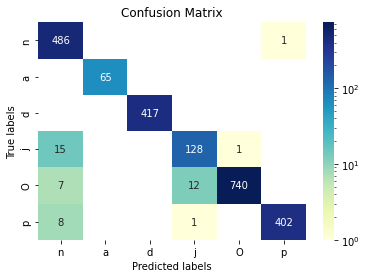

In [21]:
labels = ['n', 'a', 'd', 'j', 'O', 'p']
plot_confusion_matrix(y_test, y_pred, labels)

### Evaluate redaction performance (blackened vs. open tokens)

In [22]:
# Add an additional column containing information if something was redacted or not

blackout_labels = ["n","j","d","a"]
tok_anno_test['blackout_label'] = tok_anno_test['annotation'].apply(lambda x: x in blackout_labels)
tok_anno_test

,IDENTIFIER,td-idx,annotation,blackout_label
83,ID-910,83,n,True
84,ID-910,84,n,True
85,ID-910,85,n,True
86,ID-910,86,p,False
87,ID-910,87,d,True
...,...,...,...,...
11542,ID-2602,11542,d,True
11563,ID-1193,11563,n,True
11564,ID-1193,11564,n,True
11565,ID-1193,11565,n,True


In [23]:
# Look at evaluation scores

y_test_blackout = tok_anno_test['blackout_label'].apply(lambda x: 'blackout' if x else 'open')
y_pred_blackout = test_preds['blackout_label'].apply(lambda x: 'blackout' if x else 'open')
print(metrics.classification_report(y_test_blackout, y_pred_blackout, digits=3))

              precision    recall  f1-score   support

    blackout      0.957     0.999     0.978      1113
        open      0.999     0.960     0.979      1262

    accuracy                          0.979      2375
   macro avg      0.978     0.980     0.978      2375
weighted avg      0.979     0.979     0.979      2375



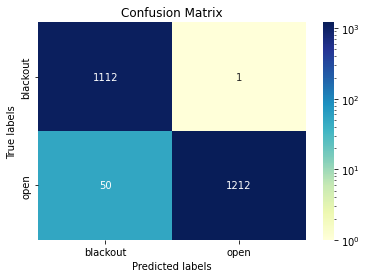

In [24]:
# Look at the confusion matrix

labels = ['blackout', 'open']
plot_confusion_matrix(y_test_blackout, y_pred_blackout, labels)

## K-fold cross validation (this may take some time!)

In [25]:
k = 3  # number of folds

kf = KFold(n_splits=k, random_state=None, shuffle=False)

kf_indices = dict()
kf_preds = dict()
kf_preds_proba = dict()
kf_scores = dict()


for i, (train_index, test_index) in enumerate(kf.split(doc_ids)):
    fold_number = i+1
    logging.info(f'Running fold number: {fold_number}')
    
    docs_train, docs_test = doc_ids[train_index], doc_ids[test_index]
    
    logging.info(f'Number documents train: {len(train_index)}; Number documentes test: {len(test_index)}')
    
    in_train_toks = tok_anno[id_field].isin(docs_train)
    in_train_docs = doc_anno[id_field].isin(docs_train)
    
    tok_feat_df_train = tok_feat_df[in_train_toks]  # training set features (token-level)
    tok_anno_train = tok_anno[in_train_toks]  # training set labels (token-level)
    tok_feat_df_test = tok_feat_df[~in_train_toks]  # test set features (token-level)
    tok_anno_test = tok_anno[~in_train_toks]  # test set labels (token-level)
    
    doc_feat_df_train = doc_feat_df[in_train_docs]  # training set features (document-level)
    doc_anno_train = doc_anno[in_train_docs]  # training set labels (document-level)
    doc_feat_df_test = doc_feat_df[~in_train_docs] # test set features (document-level)
    doc_anno_test = doc_feat_df[~in_train_docs]  # test set labels (document-level)
    
    idx_dict = {'train':docs_train, 'test':docs_test}
    
    crf_model, mlp_model, svm_model, vectorizer = train_classifiers(doc_feat_df_train,
                                                                doc_anno_train,
                                                                tok_feat_df_train,
                                                                tok_anno_train)

    models_dict = {'crf_model': crf_model, 'mlp_model': mlp_model, 'svm_model': svm_model, 'vectorizer': vectorizer}
    
    test_preds = models.predict_labels(doc_feat_df_test, tok_feat_df_test, id_field=id_field)
    
    
    kf_indices[f'run-{fold_number}'] = idx_dict
    kf_preds[f'run-{fold_number}'] = test_preds
    
    y_test = tok_anno_test['annotation']
    y_pred = test_preds['prediction']
    
    kf_scores[f'run-{fold_number}'] = metrics.classification_report(y_test, y_pred, digits=3, output_dict=True)
    
logging.info(f'Kfold cross-validation completed with k={k}.')
    

INFO:root:Running fold number: 1
INFO:root:Number documents train: 668; Number documentes test: 335
INFO:root:Training CRF classifier...
INFO:root:CRF model: training completed.
INFO:root:Training MLP Classifier...
INFO:root:MLP model: training completed.
INFO:root:Training SVM Classifier...
INFO:root:SVM model: training completed
INFO:root:Training of ensemble subsystems completed.
INFO:root:Applying models...
INFO:root:Ensembling...
INFO:root:Applying relabeling...
INFO:root:Running fold number: 2
INFO:root:Number documents train: 669; Number documentes test: 334
INFO:root:Training CRF classifier...
INFO:root:CRF model: training completed.
INFO:root:Training MLP Classifier...
INFO:root:MLP model: training completed.
INFO:root:Training SVM Classifier...
INFO:root:SVM model: training completed
INFO:root:Training of ensemble subsystems completed.
INFO:root:Applying models...
INFO:root:Ensembling...
INFO:root:Applying relabeling...
INFO:root:Running fold number: 3
INFO:root:Number docume

## Evaluate after k-fold cross validation

In [26]:
## Average evaluation scores (across folds)

cv_eval = pd.DataFrame(kf_scores).T

avg_eval = pd.DataFrame()

for c in cv_eval.columns:
    avg_eval[c] = cv_eval[c].apply(pd.Series).mean()
    
avg_eval.round(3)

,O,a,d,j,n,p,wd,accuracy,macro avg,weighted avg
precision,0.997,1.000,1.000,0.981,0.988,0.996,0.993,NaN,0.994,0.994
recall,0.994,1.000,1.000,0.977,1.000,0.996,0.962,NaN,0.990,0.994
f1-score,0.996,1.000,1.000,0.979,0.994,0.996,0.977,NaN,0.991,0.994
support,1234.000,126.667,635.333,227.333,824.667,673.667,145.333,NaN,3867.000,3867.000


In [27]:
#congregate predicted labels across all folds

preds_congregated = pd.DataFrame()

for run in kf_indices:
    run_labels = kf_preds[run]
    run_labels['run_id'] = run
    preds_congregated = preds_congregated.append(run_labels, ignore_index=True)
    
preds_congregated = preds_congregated.reset_index(drop=True)

preds_congregated

,IDENTIFIER,td-idx,token,prediction,blackout_label,run_id
0,ID-10000,0,YU,O,False,run-1
1,ID-10000,1,:,p,False,run-1
2,ID-10000,2,Vahuret,j,True,run-1
3,ID-10000,3,",",p,False,run-1
4,ID-10000,4,Givisiez,O,False,run-1
...,...,...,...,...,...,...
11596,ID-2440,11596,RS,O,False,run-3
11597,ID-2440,11597,72,O,False,run-3
11598,ID-2440,11598,/,p,False,run-3
11599,ID-2440,11599,73,O,False,run-3


### Evaluate labeling performance over congregated labels across folds

In [28]:
y_test = tok_anno['annotation']
y_pred = preds_congregated['prediction']

print(metrics.classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           O      0.997     0.994     0.996      3702
           a      1.000     1.000     1.000       380
           d      1.000     1.000     1.000      1906
           j      0.981     0.977     0.979       682
           n      0.988     1.000     0.994      2474
           p      0.996     0.996     0.996      2021
          wd      0.995     0.959     0.977       436

    accuracy                          0.994     11601
   macro avg      0.994     0.989     0.991     11601
weighted avg      0.994     0.994     0.994     11601



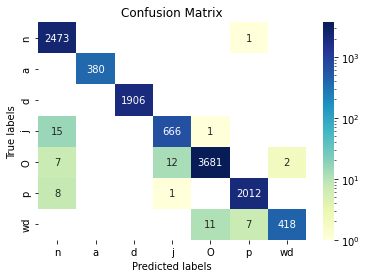

In [29]:
# Look at confusion matrix

labels = ['n', 'a', 'd', 'j', 'O', 'p', 'wd']
plot_confusion_matrix(y_test, y_pred, labels)

### Evaluate redaction performance (blackened vs. open tokens) over congregated labels across folds

In [30]:
blackout_labels = ["n","j","d","a"]
tok_anno['blackout_label'] = tok_anno['annotation'].apply(lambda x: x in blackout_labels)
tok_anno

,IDENTIFIER,td-idx,annotation,blackout_label
0,ID-10000,0,O,False
1,ID-10000,1,p,False
2,ID-10000,2,j,True
3,ID-10000,3,p,False
4,ID-10000,4,O,False
...,...,...,...,...
11596,ID-2440,11596,O,False
11597,ID-2440,11597,O,False
11598,ID-2440,11598,p,False
11599,ID-2440,11599,O,False


In [31]:
# Look at evaluation scores

y_test_blackout = tok_anno['blackout_label'].apply(lambda x: 'blackout' if x else 'open')
y_pred_blackout = preds_congregated['blackout_label'].apply(lambda x: 'blackout' if x else 'open')
print(metrics.classification_report(y_test_blackout, y_pred_blackout, digits=3))

              precision    recall  f1-score   support

    blackout      0.981     1.000     0.990      5442
        open      1.000     0.983     0.991      6159

    accuracy                          0.991     11601
   macro avg      0.990     0.991     0.991     11601
weighted avg      0.991     0.991     0.991     11601



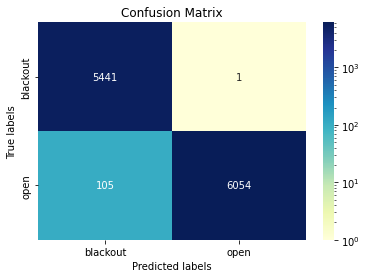

In [32]:
# Look at confusion matrix

labels = ['blackout', 'open']
plot_confusion_matrix(y_test_blackout, y_pred_blackout, labels)